In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram


In [2]:
red_wine_path = 'C:/Users/aarya/Desktop/USC University/EE599 - ML2b/Project/wine+quality/winequality-red.csv'
white_wine_path = 'C:/Users/aarya/Desktop/USC University/EE599 - ML2b/Project/wine+quality/winequality-white.csv'

In [3]:
# Load data
red_wine_data = pd.read_csv(red_wine_path, sep=';')
white_wine_data = pd.read_csv(white_wine_path, sep=';')

# Combine datasets
red_wine_data['wine_type'] = 0
white_wine_data['wine_type'] = 1
wine_data = pd.concat([red_wine_data, white_wine_data], axis=0).reset_index(drop=True)

In [4]:
# Collapse labels into 3: Low, Medium and High
def quality_label(quality):
    if quality <= 5:
        return 'Low'
    elif quality == 6:
        return 'Medium'
    else:
        return 'High'

wine_data['original_label'] = wine_data['quality'].apply(quality_label)

In [5]:
# Balance the dataset
low_data = wine_data[wine_data['original_label'] == 'Low']
medium_data = wine_data[wine_data['original_label'] == 'Medium'].sample(n=len(low_data), random_state=42)
high_data = wine_data[wine_data['original_label'] == 'High']

balanced_data = pd.concat([low_data, medium_data, high_data], axis=0).reset_index(drop=True)

In [6]:
# Preprocessing
balanced_features = balanced_data.drop(columns=['quality', 'wine_type', 'original_label'])
scaler = StandardScaler()
scaled_balanced_features = scaler.fit_transform(balanced_features)

# Dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_balanced_features)


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

# Define k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
models = ['KMeans', 'GMM', 'Hierarchical']
results = {model: {'Silhouette': [], 'NMI': [], 'ARI': []} for model in models}

# Cross-validation for clustering models
for train_index, test_index in kfold.split(pca_features):
    X_train, X_test = pca_features[train_index], pca_features[test_index]
    y_true = balanced_data['original_label'].iloc[test_index]

    # K-Means
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_train)
    kmeans_test_labels = kmeans.predict(X_test)
    results['KMeans']['Silhouette'].append(silhouette_score(X_test, kmeans_test_labels))
    results['KMeans']['NMI'].append(normalized_mutual_info_score(y_true, kmeans_test_labels))
    results['KMeans']['ARI'].append(adjusted_rand_score(y_true, kmeans_test_labels))

    # GMM
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(X_train)
    gmm_test_labels = gmm.predict(X_test)
    results['GMM']['Silhouette'].append(silhouette_score(X_test, gmm_test_labels))
    results['GMM']['NMI'].append(normalized_mutual_info_score(y_true, gmm_test_labels))
    results['GMM']['ARI'].append(adjusted_rand_score(y_true, gmm_test_labels))

    # Hierarchical Clustering
    linkage_matrix = linkage(X_train, method='ward')
    hierarchical_train_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
    linkage_matrix_test = linkage(X_test, method='ward')
    hierarchical_test_labels = fcluster(linkage_matrix_test, t=3, criterion='maxclust')
    results['Hierarchical']['Silhouette'].append(silhouette_score(X_test, hierarchical_test_labels))
    results['Hierarchical']['NMI'].append(normalized_mutual_info_score(y_true, hierarchical_test_labels))
    results['Hierarchical']['ARI'].append(adjusted_rand_score(y_true, hierarchical_test_labels))

# Average Results
print("Cross-Validation Results (Average Scores):")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, scores in metrics.items():
        print(f"  {metric}: {np.mean(scores):.4f}")


Cross-Validation Results (Average Scores):

KMeans:
  Silhouette: 0.4943
  NMI: 0.0419
  ARI: 0.0249

GMM:
  Silhouette: 0.4826
  NMI: 0.0383
  ARI: 0.0227

Hierarchical:
  Silhouette: 0.4653
  NMI: 0.0381
  ARI: 0.0223


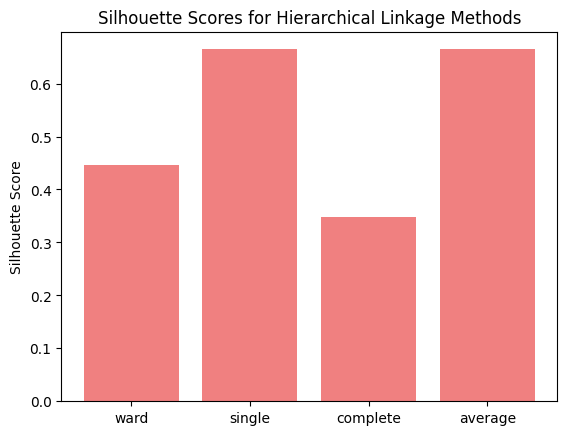

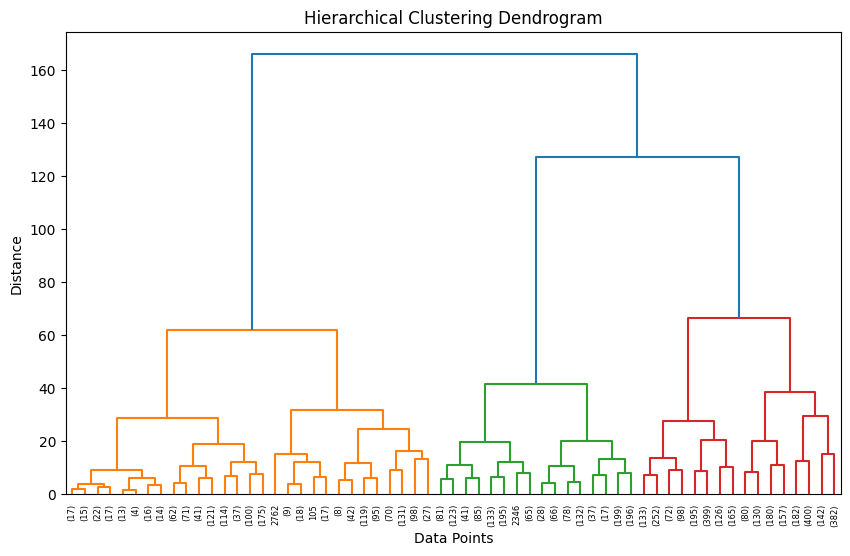

0.4453100566990244


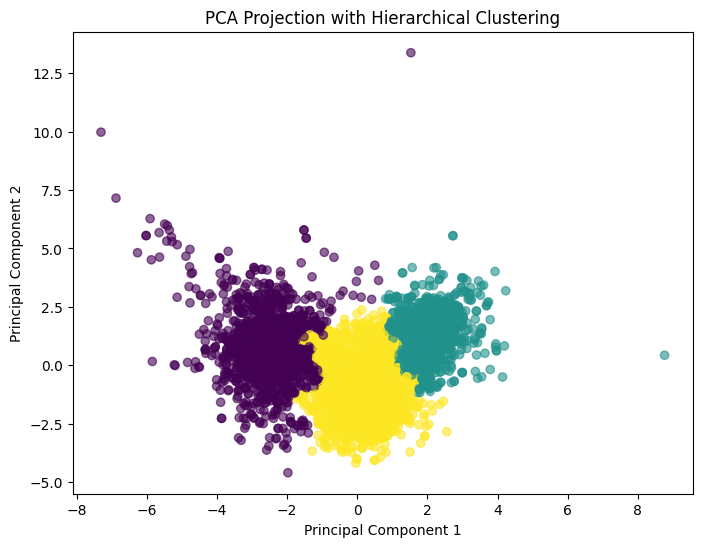

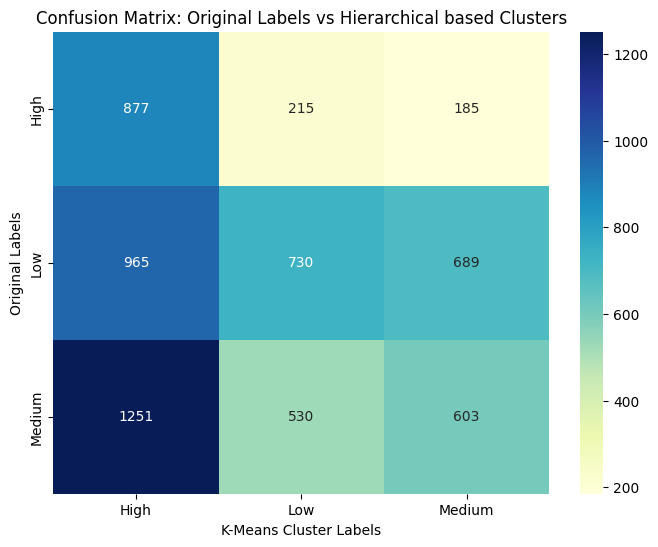

In [8]:
# Baseline: Hierarchical (Imbalanced data)

from scipy.cluster.hierarchy import fcluster, linkage
methods = ['ward', 'single', 'complete', 'average']
scores = {}
for method in methods:
    linkage_matrix = linkage(pca_features, method=method)
    clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
    score = silhouette_score(pca_features, clusters)
    scores[method] = score

plt.bar(scores.keys(), scores.values(), color='lightcoral')
plt.title('Silhouette Scores for Hierarchical Linkage Methods')
plt.ylabel('Silhouette Score')
plt.show()

# Perform Hierarchical Clustering
linkage_matrix = linkage(pca_features, method='ward') # Ward linkage minimizes intra-cluster variance

# Visualize the dendrogram to determine optimal clusters
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Show first 5 levels
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Define Clusters
hierarchical_clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
balanced_data['hierarchical_cluster_'] = hierarchical_clusters

# Evaluate the Performance
silhouette_hierarchical = silhouette_score(pca_features, hierarchical_clusters)
print(silhouette_hierarchical)

# Visualize Hierarchical Clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=hierarchical_clusters, cmap='viridis', alpha=0.6)
plt.title('PCA Projection with Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Relabel Hierarchical Clusters Based on Average Wine Quality
hierarchical_cluster_means = balanced_data.groupby('hierarchical_cluster_')['quality'].mean().sort_values()
hierarchical_cluster_relabel = {cluster: label for cluster, label in zip(hierarchical_cluster_means.index, ['Low', 'Medium', 'High'])}
balanced_data['hierarchical_cluster'] = balanced_data['hierarchical_cluster_'].map(hierarchical_cluster_relabel)

# Compare Hierarchical Clusters with Original Labels
hierarchical_confusion_matrix = pd.crosstab(balanced_data['original_label'], balanced_data['hierarchical_cluster'])

plt.figure(figsize=(8, 6))
sns.heatmap(hierarchical_confusion_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Confusion Matrix: Original Labels vs Hierarchical based Clusters')
plt.xlabel('K-Means Cluster Labels')
plt.ylabel('Original Labels')
plt.show()

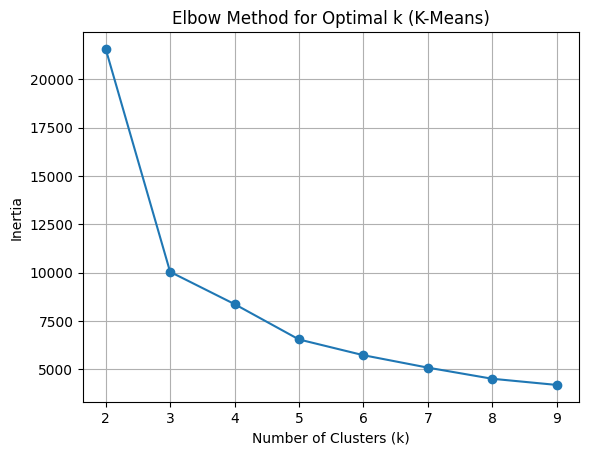

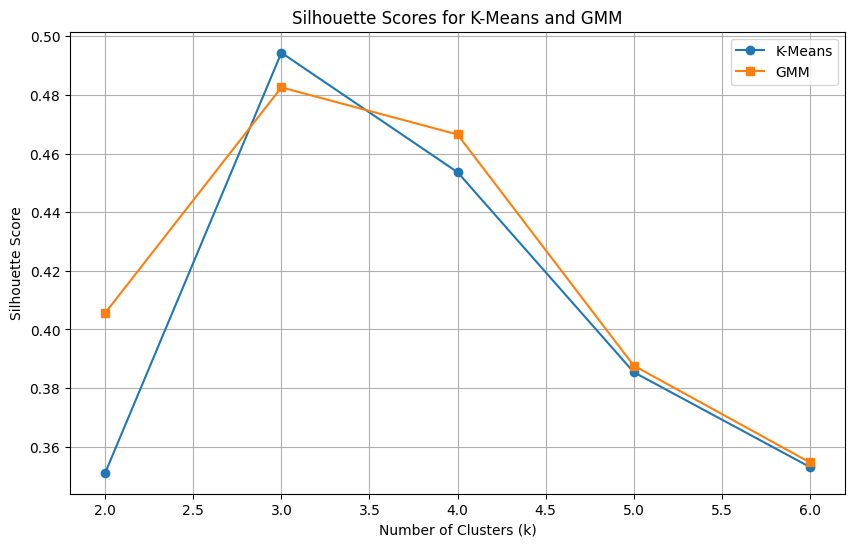

In [9]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.grid(True)
plt.show()


# Test different values of k for K-Means
k_values = range(2, 7) 
kmeans_silhouettes = []
gmm_silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_clusters = kmeans.fit_predict(pca_features)
    kmeans_silhouettes.append(silhouette_score(pca_features, kmeans_clusters))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_clusters = gmm.fit_predict(pca_features)
    gmm_silhouettes.append(silhouette_score(pca_features, gmm_clusters))

# Visualize Silhouette Scores for K-Means and GMM
plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_silhouettes, marker='o', label='K-Means')
plt.plot(k_values, gmm_silhouettes, marker='s', label='GMM')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means and GMM')
plt.legend()
plt.grid(True)
plt.show()

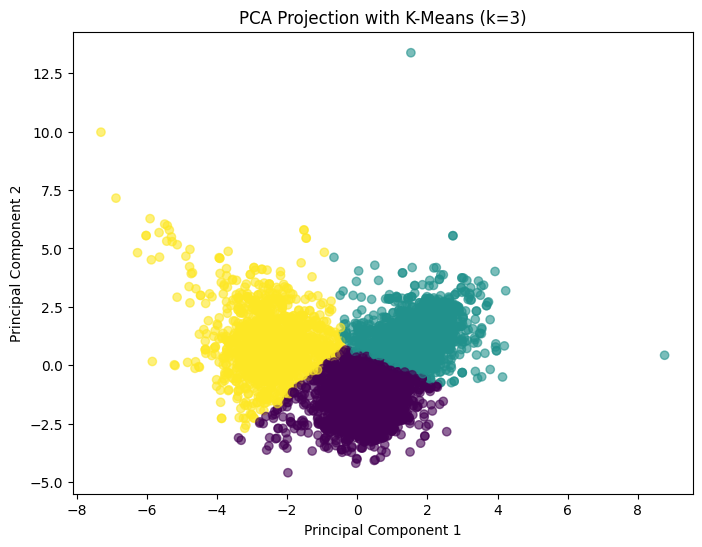

3 0.49442690768773145 0.4825964471294005


In [10]:
# PCA scatter plot with optimal k
optimal_k = k_values[np.argmax(kmeans_silhouettes)]
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
balanced_data['pca_kmeans_cluster'] = kmeans_optimal.fit_predict(pca_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=balanced_data['pca_kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title(f'PCA Projection with K-Means (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optimal k and silhouette scores
print(optimal_k, max(kmeans_silhouettes), max(gmm_silhouettes))

In [11]:
# Cluster labels based on average wine quality
kmeans_cluster_means = balanced_data.groupby('pca_kmeans_cluster')['quality'].mean().sort_values()
kmeans_cluster_relabel = {cluster: label for cluster, label in zip(
    kmeans_cluster_means.index, ['Low', 'Medium', 'High']
)}
balanced_data['kmeans_cluster_label'] = balanced_data['pca_kmeans_cluster'].map(kmeans_cluster_relabel)

# Display cluster summary
cluster_summary = balanced_data.groupby('kmeans_cluster_label')['quality'].agg(['count', 'mean'])
cluster_summary

,count,mean
kmeans_cluster_label,,
High,2753,6.068652
Low,1502,5.571238
Medium,1790,5.594972


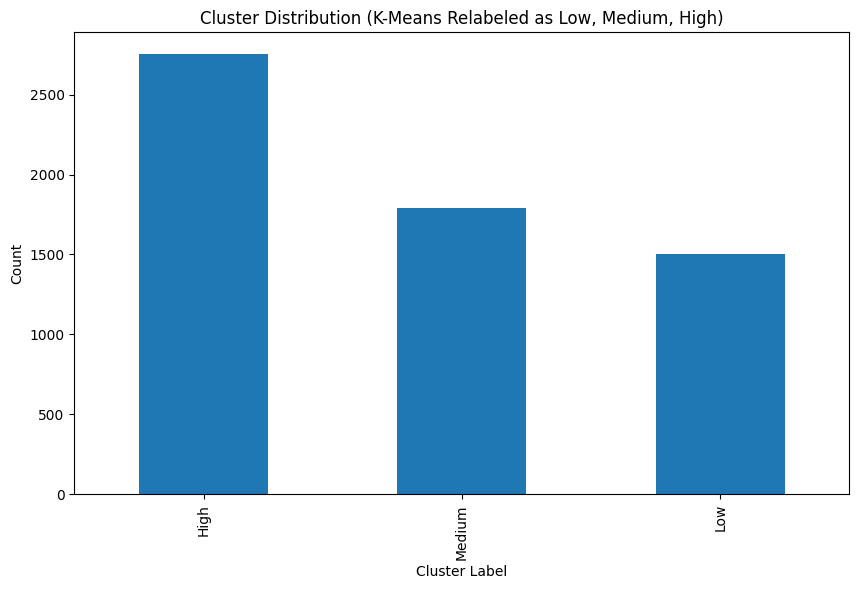

In [12]:
# Visualization: Cluster Distribution
plt.figure(figsize=(10, 6))
balanced_data['kmeans_cluster_label'].value_counts().plot(kind='bar')
plt.title('Cluster Distribution (K-Means Relabeled as Low, Medium, High)')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

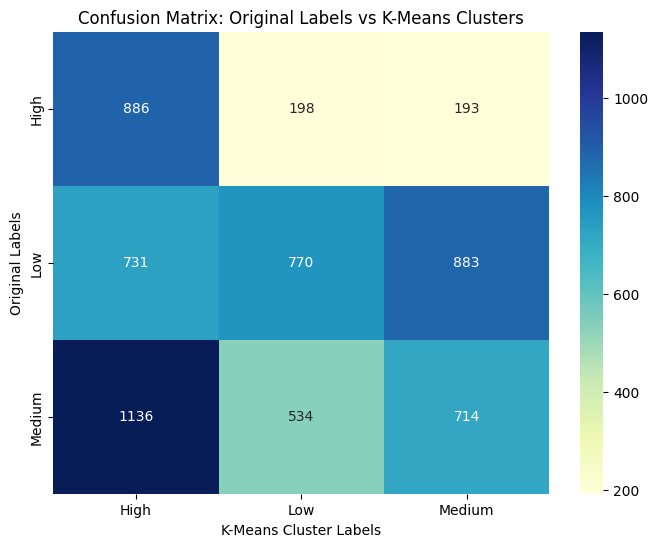

In [13]:
# Compare with original labels
knn_confusion_matrix = pd.crosstab(balanced_data['original_label'], balanced_data['kmeans_cluster_label'])

plt.figure(figsize=(8, 6))
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Confusion Matrix: Original Labels vs K-Means Clusters')
plt.xlabel('K-Means Cluster Labels')
plt.ylabel('Original Labels')
plt.show()

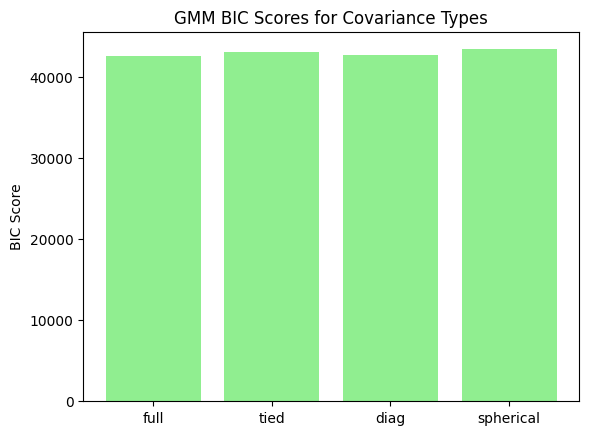

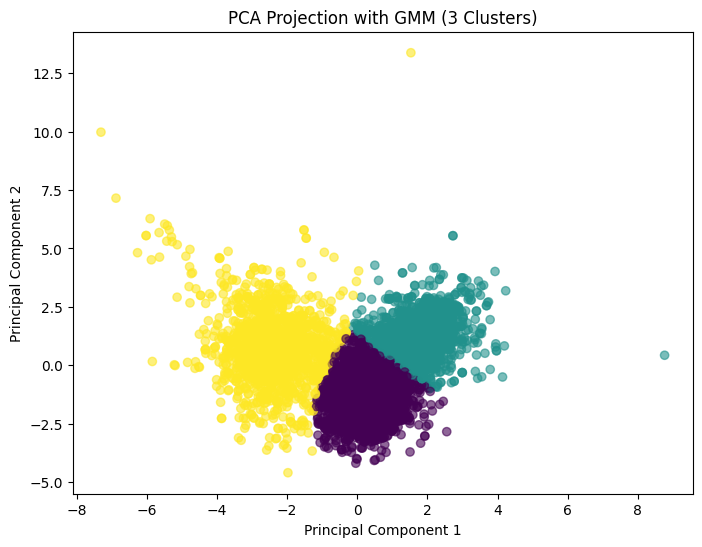

                   count      mean
gmm_cluster_label                 
High                2744  6.066691
Low                 1620  5.562346
Medium              1681  5.610946


In [14]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_balanced_features)

bic_scores = {}
for cov_type in ['full', 'tied', 'diag', 'spherical']:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm.fit(pca_features)
    bic_scores[cov_type] = gmm.bic(pca_features)

plt.bar(bic_scores.keys(), bic_scores.values(), color='lightgreen')
plt.title('GMM BIC Scores for Covariance Types')
plt.ylabel('BIC Score')
plt.show()

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=3, random_state=42)
balanced_data['gmm_cluster'] = gmm.fit_predict(pca_features)

# Visualization of GMM Clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=balanced_data['gmm_cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA Projection with GMM (3 Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Relabel clusters based on average wine quality
gmm_cluster_means = balanced_data.groupby('gmm_cluster')['quality'].mean().sort_values()
gmm_cluster_relabel = {cluster: label for cluster, label in zip(gmm_cluster_means.index, ['Low', 'Medium', 'High'])}
balanced_data['gmm_cluster_label'] = balanced_data['gmm_cluster'].map(gmm_cluster_relabel)

# Cluster summary
gmm_cluster_summary = balanced_data.groupby('gmm_cluster_label')['quality'].agg(['count', 'mean'])
print(gmm_cluster_summary)

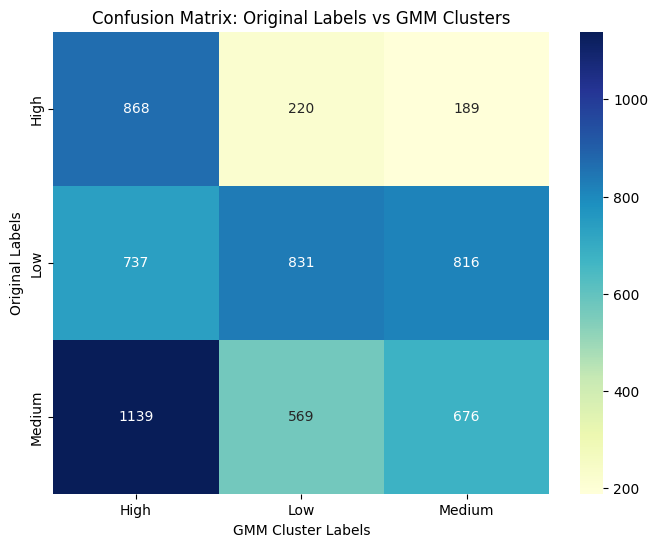

In [15]:
# Compare GMM cluster labels with original labels
gmm_confusion_matrix = pd.crosstab(balanced_data['original_label'], balanced_data['gmm_cluster_label'])

plt.figure(figsize=(8, 6))
sns.heatmap(gmm_confusion_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Confusion Matrix: Original Labels vs GMM Clusters')
plt.xlabel('GMM Cluster Labels')
plt.ylabel('Original Labels')
plt.show()

In [16]:
# Why GMM Uses EM:
# Unlike K-Means, which uses hard assignments of data points to clusters, GMM models soft assignments using probabilities.
# EM efficiently estimates the parameters of these probability distributions iteratively to maximize the likelihood of the observed data.

In [17]:
from sklearn.metrics import normalized_mutual_info_score 
nmi_kmeans = normalized_mutual_info_score(balanced_data['original_label'], balanced_data['kmeans_cluster_label'])
nmi_gmm = normalized_mutual_info_score(balanced_data['original_label'], balanced_data['gmm_cluster_label'])
nmi_hc = normalized_mutual_info_score(balanced_data['original_label'], balanced_data['hierarchical_cluster'])
print("NMI for K-Means:", nmi_kmeans)
print("NMI for GMM:", nmi_gmm)
print("NMI for Hierarchical:", nmi_hc)


NMI for K-Means: 0.04112939355839014
NMI for GMM: 0.037980228377622424
NMI for Hierarchical: 0.02214321030412768


In [18]:
from sklearn.metrics import adjusted_rand_score # Compares cluster assignments with original labels.
ari_kmeans = adjusted_rand_score(balanced_data['original_label'], balanced_data['kmeans_cluster_label'])
ari_gmm = adjusted_rand_score(balanced_data['original_label'], balanced_data['gmm_cluster_label'])
ari_hc = adjusted_rand_score(balanced_data['original_label'], balanced_data['hierarchical_cluster'])
print("ARI for K-Means:", ari_kmeans)
print("ARI for GMM:", ari_gmm)
print("ARI for Hierarchical:", ari_hc)

ARI for K-Means: 0.02547825910090152
ARI for GMM: 0.023409770119483166
ARI for Hierarchical: 0.005051081654375223


In [19]:
from sklearn.metrics import davies_bouldin_score # Lower is better
db_kmeans = davies_bouldin_score(pca_features, balanced_data['kmeans_cluster_label'])
db_gmm = davies_bouldin_score(pca_features, balanced_data['gmm_cluster_label'])
db_hc = davies_bouldin_score(pca_features, balanced_data['hierarchical_cluster'])

print("Davies-Bouldin Index for K-Means:", db_kmeans)
print("Davies-Bouldin Index for GMM:", db_gmm)
print("Davies-Bouldin Index for Hierarchical:", db_hc)

Davies-Bouldin Index for K-Means: 0.687464024977106
Davies-Bouldin Index for GMM: 0.7097441324173221
Davies-Bouldin Index for Hierarchical: 0.7582966586644163


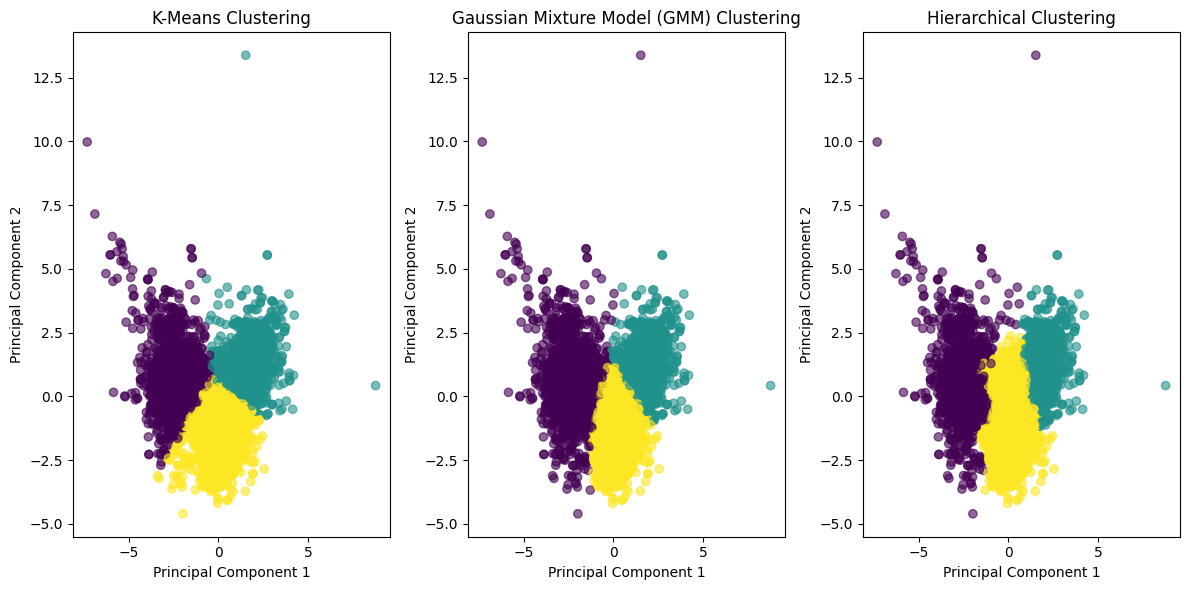

In [20]:
# Map string labels ('Low', 'Medium', 'High') to numeric values for visualization
kmeans_color_map = {'Low': 0, 'Medium': 1, 'High': 2}
gmm_color_map = {'Low': 0, 'Medium': 1, 'High': 2}

balanced_data['kmeans_cluster_numeric'] = balanced_data['kmeans_cluster_label'].map(kmeans_color_map)
balanced_data['gmm_cluster_numeric'] = balanced_data['gmm_cluster_label'].map(gmm_color_map)
balanced_data['hierarchical_cluster_numeric'] = balanced_data['hierarchical_cluster'].map(gmm_color_map)

# Visualize Hierarchical, GMM and K-Means clusters side by side
plt.figure(figsize=(12, 6))

# K-Means Clusters
plt.subplot(1, 3, 1)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=balanced_data['kmeans_cluster_numeric'], cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# GMM Clusters
plt.subplot(1, 3, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=balanced_data['gmm_cluster_numeric'], cmap='viridis', alpha=0.6)
plt.title('Gaussian Mixture Model (GMM) Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Hierarchical Clusters
plt.subplot(1, 3, 3)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=balanced_data['hierarchical_cluster_numeric'], cmap='viridis', alpha=0.6)
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

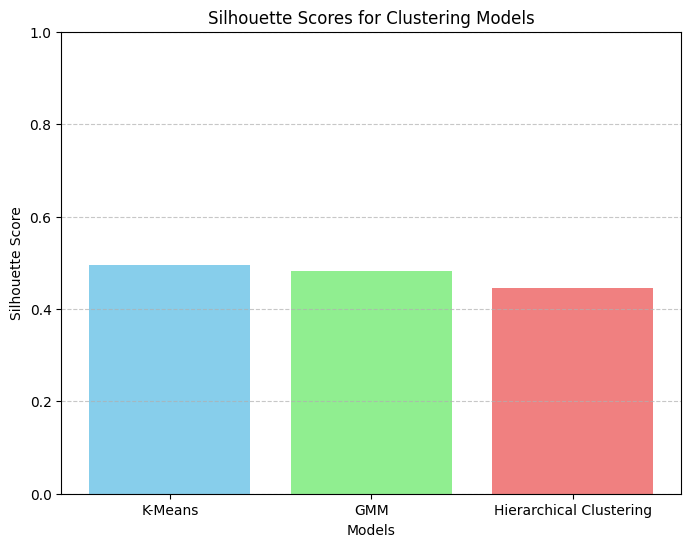

In [21]:
# Models and scores
models = ['K-Means', 'GMM', 'Hierarchical Clustering']
silhouette_scores = [max(kmeans_silhouettes), max(gmm_silhouettes), silhouette_hierarchical]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(models, silhouette_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Silhouette Scores for Clustering Models')
plt.ylabel('Silhouette Score')
plt.xlabel('Models')
plt.ylim(0, 1)  # Silhouette scores range between -1 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()